In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Load the dataset (update the file path as needed)
file_path = '/content/drive/My Drive/Colab Notebooks/Company_House_Info.csv'
data = pd.read_csv(file_path)

# Display dataset summary
print("Dataset Shape:", data.shape)
print("First 5 rows of the dataset:")
print(data.head())


Dataset Shape: (6665, 96)
First 5 rows of the dataset:
   Bankrupt?   ROA(C) before interest and depreciation before interest  \
0          1                                           0.370594          
1          1                                           0.464291          
2          1                                           0.426071          
3          1                                           0.399844          
4          1                                           0.465022          

    ROA(A) before interest and % after tax  \
0                                 0.424389   
1                                 0.538214   
2                                 0.499019   
3                                 0.451265   
4                                 0.538432   

    ROA(B) before interest and depreciation after tax  \
0                                           0.405750    
1                                           0.516730    
2                                           0.472295

In [4]:
# Remove leading and trailing spaces from column names
data.columns = data.columns.str.strip()

# Check for missing values
missing_values = data.isnull().sum()
print("Missing Values in the Dataset:\n", missing_values)


Missing Values in the Dataset:
 Bankrupt?                                                  0
ROA(C) before interest and depreciation before interest    0
ROA(A) before interest and % after tax                     0
ROA(B) before interest and depreciation after tax          0
Operating Gross Margin                                     0
                                                          ..
Liability to Equity                                        0
Degree of Financial Leverage (DFL)                         0
Interest Coverage Ratio (Interest expense to EBIT)         0
Net Income Flag                                            0
Equity to Liability                                        0
Length: 96, dtype: int64


<ipython-input-5-2f3521e59cc1>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data['Bankrupt?'], palette='coolwarm')


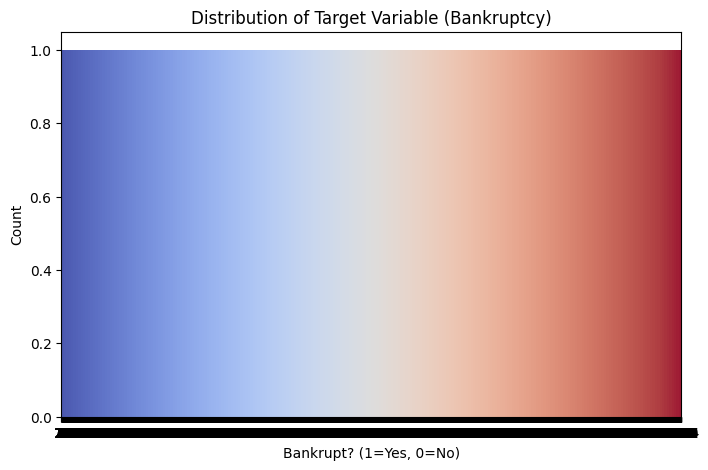

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of the target variable
plt.figure(figsize=(8, 5))
sns.countplot(data['Bankrupt?'], palette='coolwarm')
plt.title('Distribution of Target Variable (Bankruptcy)')
plt.xlabel('Bankrupt? (1=Yes, 0=No)')
plt.ylabel('Count')
plt.show()


<ipython-input-6-e8e9a9d9e82c>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[sample_feature], palette="coolwarm")


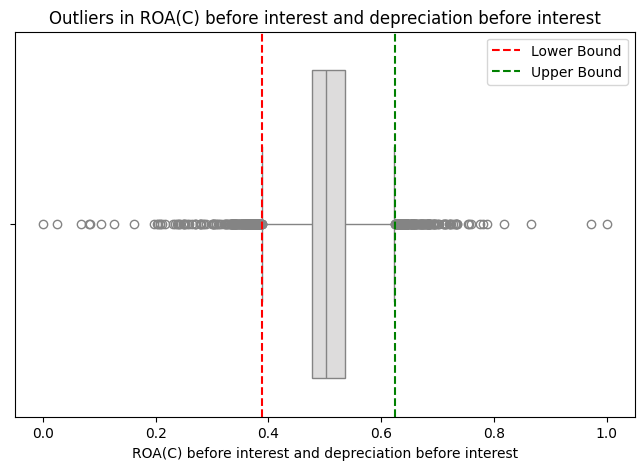

In [6]:
# Detect outliers using the IQR method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

sample_feature = 'ROA(C) before interest and depreciation before interest'
outliers, lower, upper = detect_outliers_iqr(data, sample_feature)

# Visualize outliers
plt.figure(figsize=(8, 5))
sns.boxplot(x=data[sample_feature], palette="coolwarm")
plt.axvline(lower, color='r', linestyle='--', label='Lower Bound')
plt.axvline(upper, color='g', linestyle='--', label='Upper Bound')
plt.title(f'Outliers in {sample_feature}')
plt.legend()
plt.show()


In [7]:
# Compute correlation matrix
correlation_matrix = data.corr()

# Identify highly correlated features (correlation > 0.9)
threshold = 0.9
correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            correlated_features.add(correlation_matrix.columns[i])

# Drop highly correlated features
data_reduced = data.drop(columns=correlated_features)
print(f"Dropped Features: {list(correlated_features)}")


Dropped Features: ['Net Value Per Share (A)', 'Net Income to Total Assets', 'Current Liability to Liability', 'ROA(B) before interest and depreciation after tax', 'After-tax net Interest Rate', 'Cash Flow to Sales', 'Continuous interest rate (after tax)', 'Net Value Per Share (C)', 'Gross Profit to Sales', 'Pre-tax net Interest Rate', 'Per Share Net profit before tax (Yuan ¥)', 'Net worth/Assets', 'ROA(A) before interest and % after tax', 'Realized Sales Gross Margin', 'Regular Net Profit Growth Rate', 'Liability to Equity', 'Current Liability to Equity', 'Net profit before tax/Paid-in capital', 'Operating profit/Paid-in capital']


In [8]:
from sklearn.preprocessing import StandardScaler

# Scale numerical features
numerical_features = data_reduced.select_dtypes(include=[np.number]).drop('Bankrupt?', axis=1)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numerical_features)

# Convert scaled features back to a DataFrame
scaled_data = pd.DataFrame(scaled_features, columns=numerical_features.columns)
print("Scaled Features Sample:\n", scaled_data.head())


Scaled Features Sample:
    ROA(C) before interest and depreciation before interest  \
0                                          -2.211389         
1                                          -0.669803         
2                                          -1.298629         
3                                          -1.730145         
4                                          -0.657772         

   Operating Gross Margin  Operating Profit Rate  \
0               -0.377052               0.016767   
1                0.138394               0.015002   
2               -0.377475               0.008266   
3               -1.429104              -0.003711   
4               -0.534056               0.017065   

   Non-industry income and expenditure/revenue  Operating Expense Rate  \
0                                    -0.086448               -0.619308   
1                                    -0.005846               -0.619308   
2                                    -0.140589               -0.619

<ipython-input-9-8ce6275bcea8>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette="coolwarm")


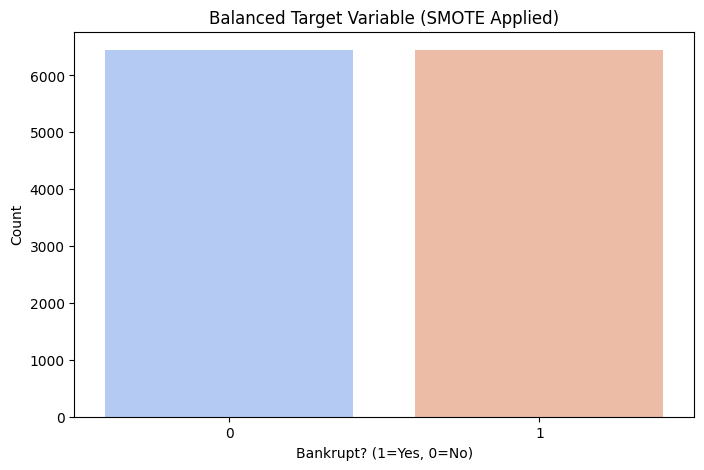

In [9]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the target variable
X = scaled_data
y = data_reduced['Bankrupt?']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Visualize the balanced target variable
plt.figure(figsize=(8, 5))
sns.countplot(x=y_resampled, palette="coolwarm")
plt.title("Balanced Target Variable (SMOTE Applied)")
plt.xlabel("Bankrupt? (1=Yes, 0=No)")
plt.ylabel("Count")
plt.show()


In [10]:
from sklearn.model_selection import train_test_split

# Assuming X (features) and y (target) are prepared after preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display the shapes of the splits
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (5332, 76)
Testing set shape: (1333, 76)


In [11]:
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression with default parameters
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Train the model on the training set
log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test)

# Display training completion
print("Logistic Regression training completed!")


Logistic Regression training completed!


In [12]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}  # Regularization strength

# Initialize Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Display the best parameter
print("Best Regularization Parameter (C):", grid_search.best_params_)

# Train the model with the best parameter
best_log_reg = grid_search.best_estimator_
best_log_reg.fit(X_train, y_train)


Best Regularization Parameter (C): {'C': 100}


LogisticRegression(C=100, max_iter=1000, random_state=42)

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

# Initialize stratified k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

# Perform cross-validation
for train_idx, val_idx in kfold.split(X, y):
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

    # Train the model with the best hyperparameters
    best_log_reg.fit(X_train_cv, y_train_cv)

    # Predict on validation set
    y_val_pred = best_log_reg.predict(X_val_cv)

    # Generate classification report for each fold
    report = classification_report(y_val_cv, y_val_pred, output_dict=True)
    cv_scores.append(report['weighted avg']['f1-score'])

# Display cross-validation results
print(f"Cross-Validation F1-Scores: {cv_scores}")
print(f"Average F1-Score: {np.mean(cv_scores):.2f}")


Cross-Validation F1-Scores: [0.9549113099037848, 0.9548854317450739, 0.9621773644990521, 0.9621773644990521, 0.9661346132380846]
Average F1-Score: 0.96


In [14]:
# Final training with the best hyperparameters
final_model = grid_search.best_estimator_
final_model.fit(X_train, y_train)

# Predict on the test set
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1]

# Generate classification report
print("Final Model - Classification Report:\n", classification_report(y_test, y_pred))


Final Model - Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1289
           1       0.48      0.25      0.33        44

    accuracy                           0.97      1333
   macro avg       0.73      0.62      0.66      1333
weighted avg       0.96      0.97      0.96      1333



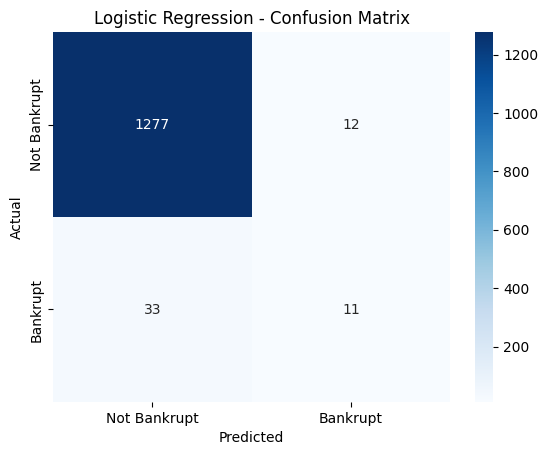

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Bankrupt", "Bankrupt"], yticklabels=["Not Bankrupt", "Bankrupt"])
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


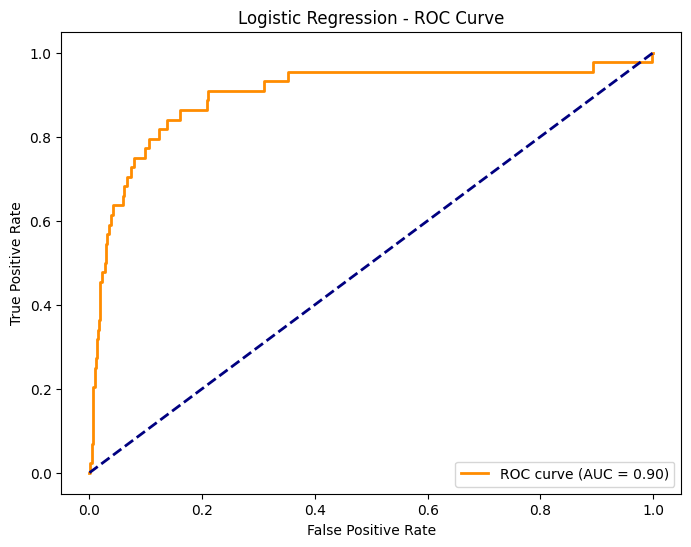

In [16]:
from sklearn.metrics import roc_curve, auc

# ROC-AUC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("Logistic Regression - ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


Decision Tree Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1289
           1       0.32      0.27      0.29        44

    accuracy                           0.96      1333
   macro avg       0.65      0.63      0.64      1333
weighted avg       0.95      0.96      0.95      1333



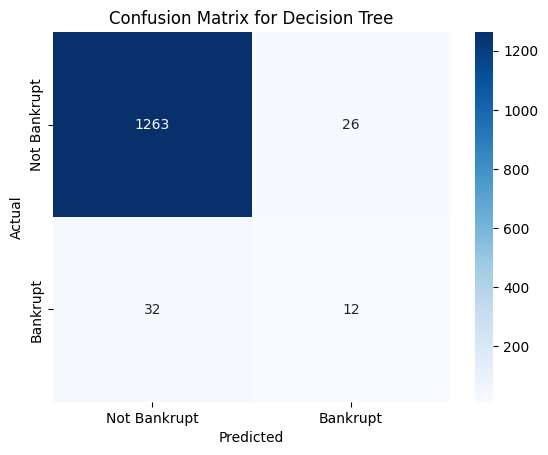

In [24]:
# Import required libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Decision Tree Model
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

# Evaluate the model
y_pred = dt_model.predict(X_test)
y_proba = dt_model.predict_proba(X_test)[:, 1]

# Classification Report
print("Decision Tree Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Bankrupt", "Bankrupt"], yticklabels=["Not Bankrupt", "Bankrupt"])
plt.title("Confusion Matrix for Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


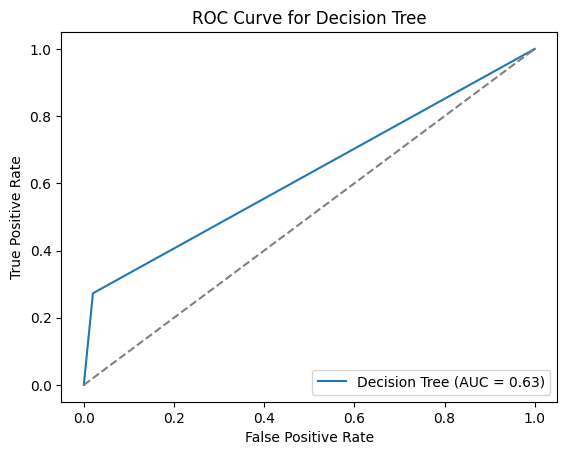

In [25]:
from sklearn.metrics import roc_curve, auc

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"Decision Tree (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve for Decision Tree")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.show()


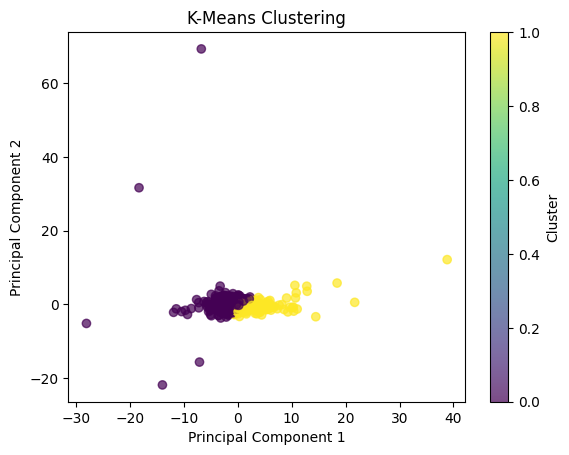

In [28]:
# Import required libraries
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# K-Means Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train)

# Predict clusters
clusters = kmeans.predict(X_test)

# PCA for visualization (reducing dimensions to 2 for plotting)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)

# Plot clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.title("K-Means Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster')
plt.show()



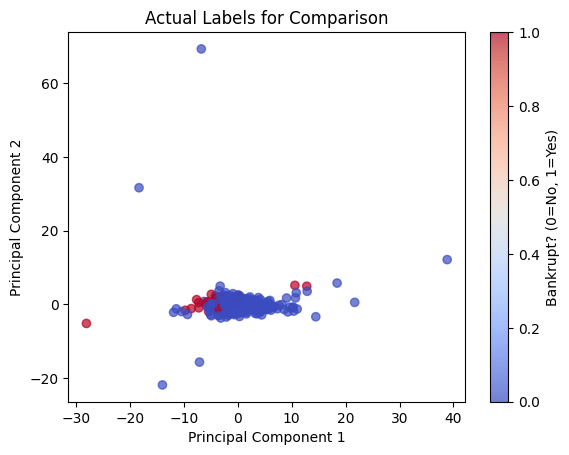

In [29]:
# Compare with actual labels (bankruptcy vs non-bankruptcy)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test, cmap='coolwarm', alpha=0.7)
plt.title("Actual Labels for Comparison")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Bankrupt? (0=No, 1=Yes)')
plt.show()


Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1289
           1       0.67      0.27      0.39        44

    accuracy                           0.97      1333
   macro avg       0.82      0.63      0.69      1333
weighted avg       0.97      0.97      0.97      1333



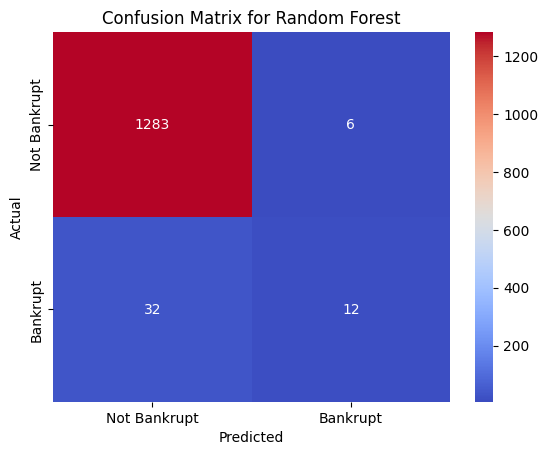

In [30]:
# Import required libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Random Forest Model
rf_model = RandomForestClassifier(random_state=42)

# Hyperparameter tuning with RandomizedSearchCV
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_search = RandomizedSearchCV(rf_model, param_grid_rf, n_iter=20, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
rf_search.fit(X_train, y_train)
rf_best_model = rf_search.best_estimator_

# Evaluate the model
y_pred = rf_best_model.predict(X_test)
y_proba = rf_best_model.predict_proba(X_test)[:, 1]

# Classification Report
print("Random Forest Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=["Not Bankrupt", "Bankrupt"], yticklabels=["Not Bankrupt", "Bankrupt"])
plt.title("Confusion Matrix for Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



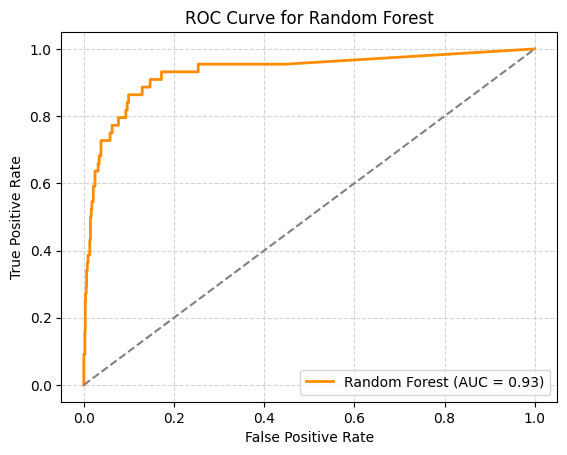

In [31]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc:.2f})", color='darkorange', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve for Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(color='lightgray', linestyle='--')
plt.show()

In [17]:
from sklearn.metrics import accuracy_score, f1_score

# Evaluate on the training set
y_train_pred = best_log_reg.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# Evaluate on the test set
y_test_pred = best_log_reg.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Display results
print(f"Training Accuracy: {train_accuracy:.2f}, Training F1-Score: {train_f1:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}")


Training Accuracy: 0.97, Training F1-Score: 0.36
Test Accuracy: 0.97, Test F1-Score: 0.33


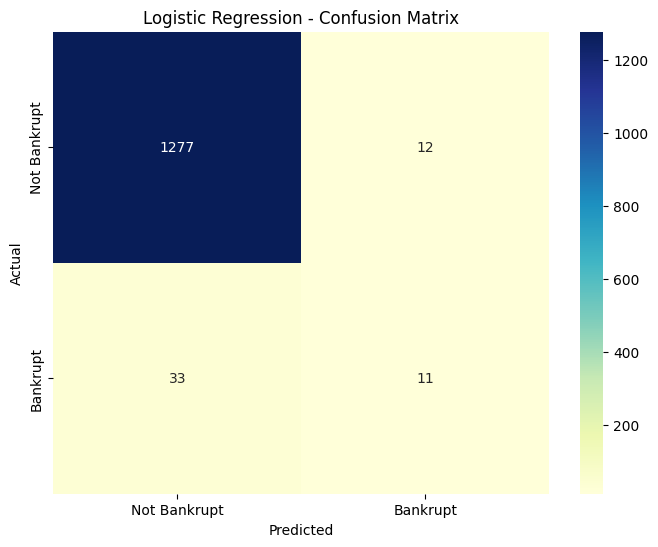

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot Confusion Matrix with a different color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=["Not Bankrupt", "Bankrupt"], yticklabels=["Not Bankrupt", "Bankrupt"])
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


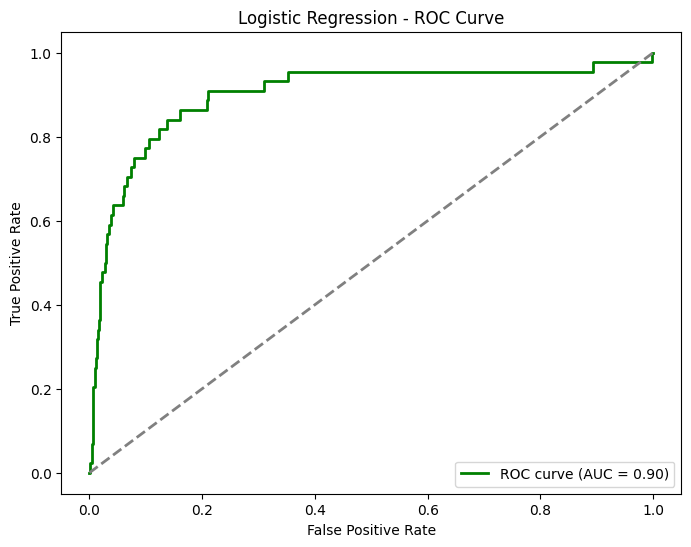

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve with a new color
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="green", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")  # Changed color to green
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")  # Reference line in gray
plt.title("Logistic Regression - ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


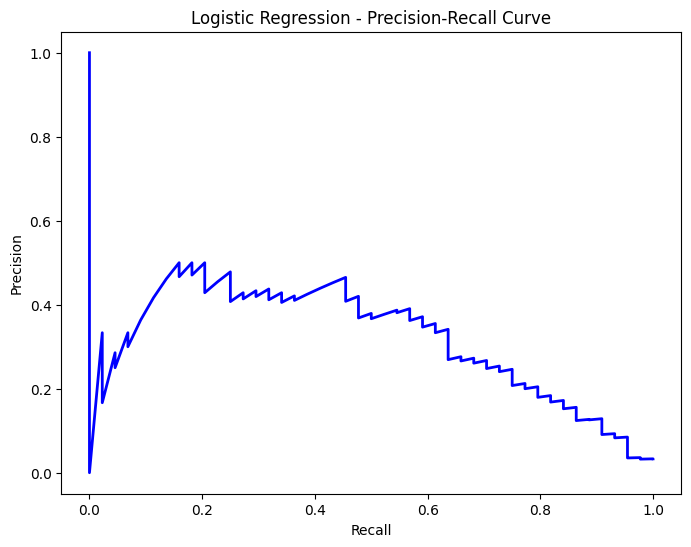

In [20]:
from sklearn.metrics import precision_recall_curve

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="blue", lw=2)
plt.title("Logistic Regression - Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


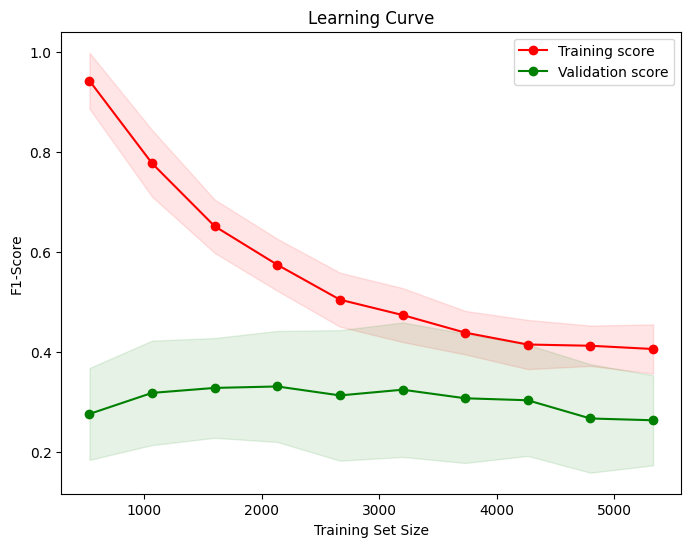

In [21]:
from sklearn.model_selection import learning_curve

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_log_reg, X, y, cv=5, scoring="f1", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation of training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Validation score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("F1-Score")
plt.legend(loc="best")
plt.show()


<ipython-input-22-7cd3ab4fbd9f>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=coefficients.head(10), palette="viridis")


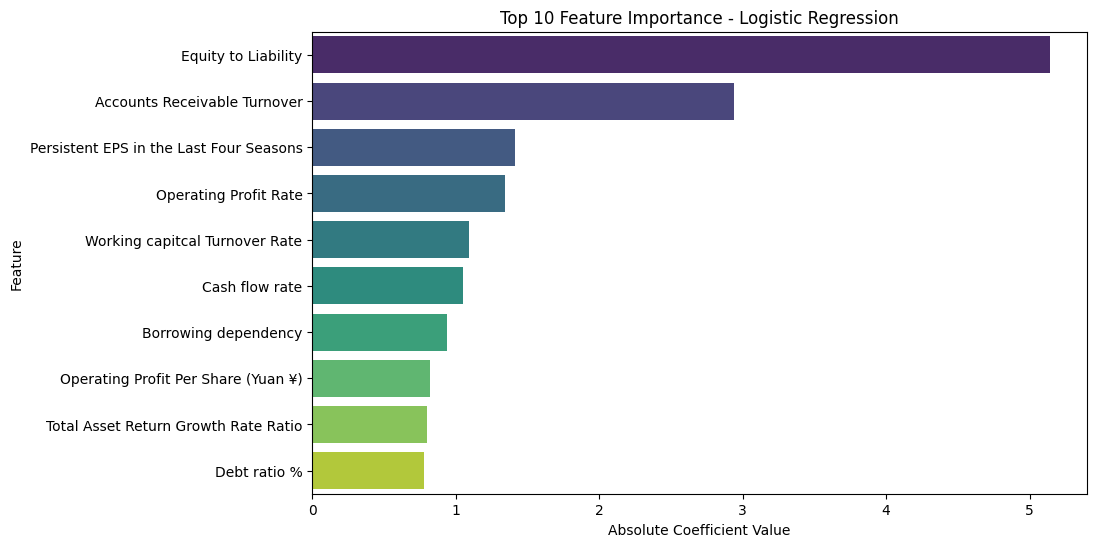

In [22]:
import pandas as pd
import numpy as np

# Get feature importance (absolute value of coefficients)
coefficients = pd.DataFrame({"Feature": X.columns, "Coefficient": best_log_reg.coef_[0]})
coefficients["Importance"] = np.abs(coefficients["Coefficient"])

# Sort by importance
coefficients = coefficients.sort_values(by="Importance", ascending=False)

# Plot top 10 important features
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=coefficients.head(10), palette="viridis")
plt.title("Top 10 Feature Importance - Logistic Regression")
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.show()
